In [1]:
from llama_index.core import (
    VectorStoreIndex,
    SimpleDirectoryReader,
    Settings,
    ServiceContext,
    StorageContext,
    load_index_from_storage,
)
from llama_index.core.embeddings.utils import resolve_embed_model
from llama_index.llms.ollama import Ollama
from llama_index.core import VectorStoreIndex, get_response_synthesizer
from llama_index.core.retrievers import VectorIndexRetriever
from llama_index.core.query_engine import RetrieverQueryEngine
from llama_index.core.postprocessor import SimilarityPostprocessor
from llama_index.core import Settings
from llama_index.core.node_parser.text.sentence import SentenceSplitter

from transformers import AutoTokenizer

import pandas as pd
pd.set_option('display.max_colwidth', None)
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from llama_cpp import Llama
from llama_cpp import LlamaGrammar

from pathlib import Path
import random
import json
import shutil

In [2]:
GENERATE_METHODS_DIR = Path('data/docs/manual')
METHODS_DIR = Path('data/docs/methods')
PROMPT_SEEDS_DIR = Path('data/prompts/generation/components')
PROMPT_COMPONENTS_DIR = Path('data/prompts/generation/components')
VAL_PROMPT_COMPONENTS_DIR = Path('data/prompts/validation/components')
GEN_PROMPTS_DIR = Path('data/prompts/generation/output')
VAL_PROMPTS_DIR = Path('data/prompts/validation/output')
PERSIST_DIR = Path("data/persist_dir")
OUTPUT_DIR = Path("output/")
DATASET_PATH = Path('data/datasets/dataset_v3.csv')
MODELS_PATH = Path('models/')

# index generation & loading

In [3]:
# default tokenizer is for gpt-3.5
# llama_index.core.global_tokenizer

In [4]:
# documents = SimpleDirectoryReader(METHODS_DIR).load_data()

# embed_tokenizer = AutoTokenizer.from_pretrained(
#     "BAAI/bge-base-en-v1.5"
# )
# Settings.text_splitter = SentenceSplitter(chunk_size=768, tokenizer=embed_tokenizer)

# Settings.embed_model = resolve_embed_model("local:BAAI/bge-base-en-v1.5")

# index = VectorStoreIndex.from_documents(
#     documents, show_progress=True
# )

# index.storage_context.persist(persist_dir=PERSIST_DIR)

In [5]:
Settings.embed_model = resolve_embed_model("local:BAAI/bge-base-en-v1.5")

# rebuild storage context
storage_context = StorageContext.from_defaults(persist_dir=PERSIST_DIR)

# load index
index = load_index_from_storage(storage_context, show_progress=True)

In [6]:
retriever = VectorIndexRetriever(
    index=index,
    similarity_top_k=3,
)

# check index

In [7]:
# Assuming you have an instance of TreeIndex named tree_index
ref_doc_info = index.ref_doc_info

# Now you can iterate over the ref_doc_info to view each node's details
with open('temp/index.txt', 'w') as f:
    for node_id, node_info in ref_doc_info.items():
        f.write(f"Node ID: {node_id}\n")
        f.write(f"Node Info: {node_info}\n")

In [8]:
# r = retriever.retrieve('Get status of a cover.')
# print(r)

# llm loading (skip)

In [9]:
llm = Llama('models/mistral-7b-instruct-v0.2.Q6_K.gguf', n_ctx=4000, verbose=False, n_gpu_layers=25) # mistral-7b-instruct-v0.2.Q4_0.gguf mistral-7b-instruct-v0.2.Q4_K_M.gguf

ggml_init_cublas: GGML_CUDA_FORCE_MMQ:   no
ggml_init_cublas: CUDA_USE_TENSOR_CORES: yes
ggml_init_cublas: found 1 CUDA devices:
  Device 0: NVIDIA GeForce RTX 2080, compute capability 7.5, VMM: yes


In [10]:
prompt = """
Command: Please, close the living room blinds slowly for 20 seconds.

What is the function user want to call in smart home?
"""
llm.create_chat_completion(messages=[{'role': 'user', 'content': prompt}], max_tokens=100)

{'id': 'chatcmpl-d1b9eec8-3fc0-4fcb-b44d-6ec5a8015809',
 'object': 'chat.completion',
 'created': 1711724514,
 'model': 'models/mistral-7b-instruct-v0.2.Q6_K.gguf',
 'choices': [{'index': 0,
   'message': {'role': 'assistant',
    'content': " The user wants to call a function to close the living room blinds gradually over a period of 20 seconds in their smart home system. This can typically be achieved by using an automation or scene feature within the smart home app, allowing the user to control the blinds' closing speed and duration."},
   'finish_reason': 'stop'}],
 'usage': {'prompt_tokens': 43, 'completion_tokens': 62, 'total_tokens': 105}}

In [11]:
!nvidia-smi

Fri Mar 29 17:01:59 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0 Off |                  N/A |
| 23%   31C    P2    50W / 215W |   6562MiB /  8192MiB |     20%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# prompt preparation

In [7]:
def get_base_prompt_variables():
    json_scheme_prompt = {
        "method": {
            "type": "string"
        },
        "params": {
            "type": "object"
        }
    }

    example_1_json = {
      "method":"Cover.Open",
      "params":
      {
        "id":2
      }
    }

    example_2_json = {
      "method":"Cover.Close",
      "params":
      {
        "id":100,
        "duration":5,
      }
    }

    with open(VAL_PROMPT_COMPONENTS_DIR / 'instruction.md') as f:
      instruction = f.read()

    variables = {
    "instruction": instruction,
    "json_scheme": "The output JSON should follow the next scheme: " + json.dumps(json_scheme_prompt),
    "example_1": """Devices: Smoke id=15, Cover id=2, Temperature id=10
Methods:
API method 1:
Method name: Cover.Open
Method description: 
Properties:
{"id": {"type": "number", "description": "The numeric ID of the Cover component instance"}, "duration": {"type": "number", "description": "If duration is not provided, Cover will fully open, unless it times out because of maxtime_open first. If duration (seconds) is provided, Cover will move in the open direction for the specified time. duration must be in the range [0.1..maxtime_open]Optional"}}
Response:
null on success; error if the request can not be executed or failed

Command: Open the cover.
JSON: """ + json.dumps(example_1_json),

    "example_2": """Devices: Cover id=100, Light id=5, Switch id=7
Methods: 
API method 1:
Method name: Cover.Close
Method description:
Properties:
{"id": {"type": "number", "description": "The numeric ID of the Cover component instance"}, "duration": {"type": "number", "description": "If duration is not provided, Cover will fully close, unless it times out because of maxtime_close first. If duration (seconds) is provided, Cover will move in the close direction for the specified time. duration must be in the range [0.1..maxtime_open]Optional"}}
Response:
null on success; error if the request can not be executed or failed

Command: Close the kitchen cover quickly (for 5 seconds).
JSON: """ + json.dumps(example_2_json),
    }

    return variables

In [8]:
def get_base_prompt():
    base_prompt_template = """
{instruction}
{json_scheme}

{example_1}

{example_2}
    """

    variables = get_base_prompt_variables()

    base_prompt = base_prompt_template.format(**variables)

    return base_prompt

def get_user_prompt_template():
    user_prompt_template = """Devices: {env}
Methods:
{methods_description}

Command: {user_cmd}
JSON:
    """

    return user_prompt_template

print(get_base_prompt())


You are a helpful AI Assistant that controls devices in a house. For a given user command create a corresponding JSON object. In any case you mustn't include JSON fields that equal null because null will break the smart home system. Don't include field instead of setting field to null. Output must be strictly in JSON format.
The output JSON should follow the next scheme: {"method": {"type": "string"}, "params": {"type": "object"}}

Devices: Smoke id=15, Cover id=2, Temperature id=10
Methods:
API method 1:
Method name: Cover.Open
Method description: 
Properties:
{"id": {"type": "number", "description": "The numeric ID of the Cover component instance"}, "duration": {"type": "number", "description": "If duration is not provided, Cover will fully open, unless it times out because of maxtime_open first. If duration (seconds) is provided, Cover will move in the open direction for the specified time. duration must be in the range [0.1..maxtime_open]Optional"}}
Response:
null on success; erro

# logging

In [9]:
# import logging
# import sys

# logging.basicConfig(stream=sys.stdout, level=logging.DEBUG)
# logger = logging.getLogger()
# logger.addHandler(logging.StreamHandler(stream=sys.stdout))

In [10]:
# logger.disabled = True

# predict

In [11]:
# output_num = list(sorted([int(d.name.replace('output', '')) for d in list(OUTPUT_DIR.glob('output*'))]))[-1] + 1
# CUR_OUTPUT_DIR = OUTPUT_DIR / f'output{output_num}'
# CUR_OUTPUT_DIR.mkdir(exist_ok=True, parents=True)

In [12]:
MODELS = {
    'mistral-7b': 'mistral-7b-instruct-v0.2.Q6_K.gguf'
}

In [17]:
def predict_prompt(llm, prompt):
    with open('data/grammars/json.gbnf') as f:
        grammar_str = f.read()
    llama_grammar = LlamaGrammar.from_string(grammar_str)
    
    response = llm.create_chat_completion(
        messages=[
            {'role': 'user', 'content': prompt}
        ],
        grammar=llama_grammar
    )
    
    response_text = response['choices'][0]['message']['content']
    response_text = response_text.replace('\_', '_')

    try:
        json_cmd = json.dumps(json.loads(response_text))
    except Exception as e:
        print(e)
        print(response_text)
        return ""

    return json_cmd

def get_methods_description(retrieved_nodes):
    methods_names = []
    methods_description = ''
    for k, node in enumerate(retrieved_nodes):
        methods_description += f'API method {k}:\n{node.text}\n\n'
        method_name = node.metadata['file_name'].replace('.md', '')
        methods_names.append(method_name)

    methods_names = ','.join(methods_names)
    methods_description = methods_description.strip('\n')

    return methods_names, methods_description

def predict(llm, df, run_name, num_nodes=3, selected_devices=None, selected_ids=None, limit_rows=None, verbose=False):
    output_path = OUTPUT_DIR / run_name / 'output.csv'

    # before filtering because we need a whole list of devices
    devices = list(df['device'].unique())

    if selected_devices:
        df = df[df['device'].isin(selected_devices)].sort_index()
    
    if selected_ids:
        df = df[df['id'].isin(selected_ids)]

    if limit_rows:
        df = df.iloc[:limit_rows]

    output_df = pd.DataFrame(columns=['id', 'device', 'user_cmd', 'mtd', 'json_cmd'])
    for i, row in df.iterrows():
        print(i)
        user_cmd = row['user_cmd']

        device = row['device']
        sample_devices = devices.copy()
        sample_devices.remove(device)
        sample_devices = random.sample(sample_devices, k=2)
        env = f'{sample_devices[0]} id=8, {sample_devices[1]} id=13, {device} id=444'

        retrieval_prompt = "Represent this sentence for searching relevant passages: " + user_cmd
        retrieved_nodes = retriever.retrieve(retrieval_prompt)
        
        completed = False
        while (not completed) and (num_nodes > 0):
            try:
                methods_names, methods_description = get_methods_description(retrieved_nodes[:num_nodes])

                user_prompt = get_user_prompt_template().format(**{'env': env, 
                                                            'methods_description': methods_description, 
                                                            'user_cmd': user_cmd})
                prompt = get_base_prompt() + '\n\n' + user_prompt

                json_cmd = predict_prompt(llm, prompt)

                completed = True
            except Exception as e:
                print(e)

                num_nodes -= 1
        
        if verbose:
            print(f'{prompt}\n')
            print('<<<------------------------------------------>>>\n\n')
        
        if json_cmd == "":
            continue

        output_series = pd.Series({'id': row['id'], 'device': row['device'], 'user_cmd': user_cmd, 'mtd': methods_names, 'json_cmd': json_cmd})
        output_df.loc[len(output_df)] = output_series

        if i == df.index[0]:
            header = True
            mode = 'w'
        else:
            header = False
            mode = 'a'
        output_df.iloc[[len(output_df)-1]].to_csv(output_path, index=False, header=header, mode=mode)
    
    return output_df

In [19]:
df = pd.read_csv(DATASET_PATH)
RUN_NAME = 'baseline'
NUM_EXAMPLES = 2
NUM_NODES = 3
MODEL_NAME = 'mistral-7b'
N_CTX = 4000

(OUTPUT_DIR / RUN_NAME).mkdir(exist_ok=True)

with open(OUTPUT_DIR / RUN_NAME / "settings.json", 'w') as f:
    f.write(json.dumps({
        'llm': MODEL_NAME,
        'num_examples': 2,
        'num_nodes': NUM_NODES,
        'num_examples': NUM_EXAMPLES,
        'n_ctx': N_CTX
    }))
shutil.copy(VAL_PROMPT_COMPONENTS_DIR / 'instruction.md', OUTPUT_DIR / RUN_NAME)

llm = Llama(str(MODELS_PATH / MODELS[MODEL_NAME]), n_ctx=N_CTX, verbose=False, n_gpu_layers=25)

output_df = predict(llm, df, RUN_NAME, num_nodes=NUM_NODES, limit_rows=3, verbose=True)

ggml_backend_cuda_buffer_type_alloc_buffer: allocating 4266.41 MiB on device 0: cudaMalloc failed: out of memory
llama_model_load: error loading model: failed to allocate buffer
llama_load_model_from_file: failed to load model


ValueError: Failed to load model from file: models/mistral-7b-instruct-v0.2.Q6_K.gguf

In [68]:
VAL_PROMPTS_DIR

PosixPath('data/prompts/validation/output')

In [20]:
output_df.tail()

,id,device,user_cmd,mtd,json_cmd
0,0,Switch,Set the dining room switch to flip mode.,"Switch.Set,Switch.SetConfig","{""method"": ""Switch.SetConfig"", ""params"": {""id"": 444, ""config"": {""in_mode"": ""flip""}}}"
1,1,Switch,Set the living room switch to cycle mode.,"Switch.Set,Switch.SetConfig","{""method"": ""Switch.SetConfig"", ""params"": {""id"": 444, ""config"": {""in_mode"": ""cycle""}}}"
2,2,Switch,Enable Automatic OFF for the kitchen switch with a delay of 10 seconds.,"Switch.SetConfig,Switch.Set","{""method"": ""Switch.SetConfig"", ""params"": {""id"": 444, ""config"": {""auto_off"": true, ""auto_off_delay"": 10}}}"
3,3,Switch,Set the bedroom switch name to 'Bed Lamp'.,"Light.SetConfig,Light.Set","{""method"": ""Light.SetConfig"", ""params"": {""id"": 1, ""config"": {""name"": ""Bed Lamp""}}}"
4,4,Switch,Set the hallway switch power limit to 50 Watts.,"Light.Set,Switch.SetConfig","{""method"": ""Switch.SetConfig"", ""params"": {""id"": 444, ""config"": {""power_limit"": 50}}}"


# evaluation

In [3]:
# df = pd.read_csv(METHODS_DIR.parent / 'methods_json.csv')

# for i, row in df.iterrows():
#     # if row['method'].split('.')[1] != 'SetConfig':
#     #     continue
#     raw_json = json.loads(row['json'])
#     raw_json = {'method': row['method'], 'params': {'type': 'object', 'properties': raw_json}}
#     row['json'] = json.dumps(raw_json)


# df.to_csv(METHODS_DIR.parent / 'methods_json_edited_2.csv', index=False, header=True)

In [45]:
# necessary properties are absent
# returns True if check failed
def check_necessary_parameters(gt_json, pred_json):
    for key, val in gt_json.items():
        if key not in pred_json:
            return True
        if type(val) == dict:
            if check_necessary_parameters(val, pred_json[key]):
                return True
    return False

# some additional from method doc (with or without necessary)
def check_additional_parameters(gt_json, pred_json, json_scheme):
    for key, val in pred_json.items():
        if key not in json_scheme:
                continue
        if key not in gt_json:
            return True
        if type(val) == dict:
            try:
                if check_additional_parameters(val, gt_json[key], json_scheme[key]['properties']):
                    return True
            except Exception as e:
                print(e)
                print(key, pred_json, gt_json, json_scheme, sep='\n')
    return False

# hallucinated properties that aren’t described in method doc
def check_hallucinated_parameters(pred_json, json_scheme):
    for key, val in pred_json.items():
        if key not in json_scheme:
            return True
        if type(val) == dict:
            if check_hallucinated_parameters(val, json_scheme[key]['properties']):
                return True
    return False

# incorrect value of parameter from prediction
def check_correctness_parameters(gt_json, pred_json):
    for key, val in pred_json.items():
        if key not in gt_json:
                continue
        if type(val) == dict:
            if check_correctness_parameters(val, gt_json[key]):
                return True
        elif gt_json[key] != val:
            return True
    return False

def check_correctness_json(gt_json, pred_json):
    return gt_json == pred_json

def compare_gt_pred(output_df, gt_df):
    merged_df = gt_df.merge(output_df, how='inner', on='id', suffixes=("_gt", "_pred"))
    json_schemes_df = pd.read_csv(METHODS_DIR.parent / 'methods_json_edited_really_last.csv')
    compared_df = pd.DataFrame(columns=['id', 'device', 'user_cmd', 'gt_mtd', 'pred_mtd', 'gt_json_cmd', 'pred_json_cmd',
                                               'retriever_cor', 'json_cor', 'add', 'hall', 'absent', 'incor'])
    for _, row in merged_df.iterrows():
        methods_names_pred = row['mtd_pred'].split(',')
        try:
            gt_json = json.loads(row['json_cmd_gt'])
            pred_json = json.loads(row['json_cmd_pred'])
        except Exception as ex:
            print(ex)
            print(row['id'])
            print(row['json_cmd_gt'])
            print(row['json_cmd_pred'])
            continue
        method_name = pred_json['method']
        method_df = json_schemes_df[json_schemes_df['method'] == method_name]
        if method_df.shape[0] == 0:
            json_scheme = None
        else:
            json_scheme = json.loads(method_df.iloc[0]['json'])
        compared_dict = {'id': row['id'], 'device': row['device_gt'],
            'user_cmd': row['user_cmd_gt'], 'gt_mtd': row['mtd_gt'],
            'pred_mtd': row['mtd_pred'], 'gt_json_cmd': row['json_cmd_gt'], 'pred_json_cmd': row['json_cmd_pred']}
        
        compared_dict['retriever_cor'] = row['mtd_gt'] in methods_names_pred
        compared_dict['json_cor'] = check_correctness_json(gt_json, pred_json)
        compared_dict['absent'] = check_necessary_parameters(gt_json, pred_json)
        compared_dict['incor'] = check_correctness_parameters(gt_json, pred_json)
        if json_scheme:
            compared_dict['add'] = check_additional_parameters(gt_json, pred_json, json_scheme)
            compared_dict['hall'] = check_hallucinated_parameters(gt_json, json_scheme)
        else:
            compared_dict['add'] = False
            compared_dict['hall'] = False

        compared_df.loc[len(compared_df)] = pd.Series(compared_dict)
    return compared_df

In [49]:
def evaluate(gt_df, output_df, run_name, settings, save_intermediate=False, verbose=False):
    compared_df = compare_gt_pred(output_df, gt_df)
    if save_intermediate:
        compared_df.to_csv(OUTPUT_DIR / run_name / 'compared.csv', index=False)
    if verbose:
        print(len(gt_df))
        print(len(compared_df))

    results_df = pd.DataFrame(columns=['run_name', 'settings', 'method_acc', 'json_acc'])

    method_acc = compared_df[compared_df['retriever_cor'] == True].shape[0] / compared_df.shape[0]
    json_acc = compared_df[compared_df['json_cor'] == True].shape[0] / compared_df.shape[0]
    results_df.loc[0] = pd.Series({'run_name': run_name,
                                    'settings': settings,
                                    'method_acc': method_acc,
                                    'json_acc': json_acc})
    results_df.to_csv(OUTPUT_DIR / 'results.csv', index=False, header=not (OUTPUT_DIR / 'results.csv').exists(), mode='a')

    fail_reasons_df = compared_df[compared_df['retriever_cor'] == True].copy(deep=True)
    fail_reasons_df = fail_reasons_df.loc[:, ['gt_mtd', 'retriever_cor', 'json_cor', 'add', 'hall', 'absent', 'incor']]
    fail_reasons_df.rename(columns={'gt_mtd': 'method'}, inplace=True)
    fail_reasons_df = fail_reasons_df.replace({True: 1, False: 0})
    fail_reasons_df = fail_reasons_df.groupby('method', as_index=False).sum()
    fail_reasons_df.insert(0, 'run_name', run_name)
    fail_reasons_df.to_csv(OUTPUT_DIR / 'fail_reasons.csv', index=False, header=not (OUTPUT_DIR / 'fail_reasons.csv').exists(), mode='a')

In [50]:
def plot_results(run_names):
    df = pd.read_csv(OUTPUT_DIR / 'results.csv')
    df = df[df['run_name'].isin(run_names)]
    fig, axs = plt.subplots(ncols=2, figsize=(10, 5))

    sns.barplot(data=df, x="run_name", y="method_acc", ax=axs[0])
    axs[0].set(xlabel='Run', ylabel='', title="Retriever accuracy")
    axs[0].tick_params(axis='x', rotation=45)

    sns.barplot(data=df, x="run_name", y="json_acc", ax=axs[1])
    axs[1].set(xlabel='Run', ylabel='', title="LLM accuracy")
    axs[1].tick_params(axis='x', rotation=45)

    fig.tight_layout()
    plt.show()

In [65]:
def plot_fail_reasons(run_names):
    df = pd.read_csv(OUTPUT_DIR / 'fail_reasons.csv')
    df = df[df['run_name'].isin(run_names)]
    df['method'] = df['method'].apply(lambda x: x.split('.')[1])
    fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(14, 14))
    ymax = 20

    order = df.groupby('method')['add'].sum().sort_values(ascending=False).index
    sns.barplot(data=df, x="method", y="add", hue="run_name", estimator='sum', order=order, ax=axs[0][0], errorbar=None)
    axs[0][0].set(xlabel='', ylabel='', title="Additional parameters", ylim=(0, ymax))
    axs[0][0].tick_params(axis='x', rotation=90)
    
    order = df.groupby('method')['hall'].sum().sort_values(ascending=False).index
    sns.barplot(data=df, x="method", y="hall", hue="run_name", estimator='sum', order=order, ax=axs[0][1], errorbar=None)
    axs[0][1].set(xlabel='', ylabel='', title="Hallucinated parameters", ylim=(0, ymax))
    axs[0][1].tick_params(axis='x', rotation=90)

    order = df.groupby('method')['absent'].sum().sort_values(ascending=False).index
    sns.barplot(data=df, x="method", y="absent", hue="run_name", estimator='sum', order=order, ax=axs[1][0], errorbar=None)
    axs[1][0].set(xlabel='', ylabel='', title="Absent parameters", ylim=(0, ymax))
    axs[1][0].tick_params(axis='x', rotation=90)

    order = df.groupby('method')['incor'].sum().sort_values(ascending=False).index
    sns.barplot(data=df, x="method", y="incor", hue="run_name", estimator='sum', order=order, ax=axs[1][1], errorbar=None)
    axs[1][1].set(xlabel='', ylabel='', title="Incorrect parameters", ylim=(0, ymax))
    axs[1][1].tick_params(axis='x', rotation=90)

    sns.despine()
    fig.tight_layout()
    plt.show()

In [52]:
# df = pd.read_csv(OUTPUT_DIR / 'fail_reasons.csv')
# df['method'] = df['method'].apply(lambda x: x.split('.')[1])
# df.groupby('method')['add'].sum().sort_values(ascending=False)

In [54]:
df = pd.read_csv(DATASET_PATH)
run_name = 'base2'

output_df = pd.read_csv(OUTPUT_DIR / run_name / 'output.csv')

with open(OUTPUT_DIR / run_name / 'settings.json') as f:
    settings = f.read()
settings = json.loads(settings)

evaluate(df, output_df, run_name, settings, save_intermediate=True)

/tmp/ipykernel_3199048/2979620283.py:22: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  fail_reasons_df = fail_reasons_df.replace({True: 1, False: 0})


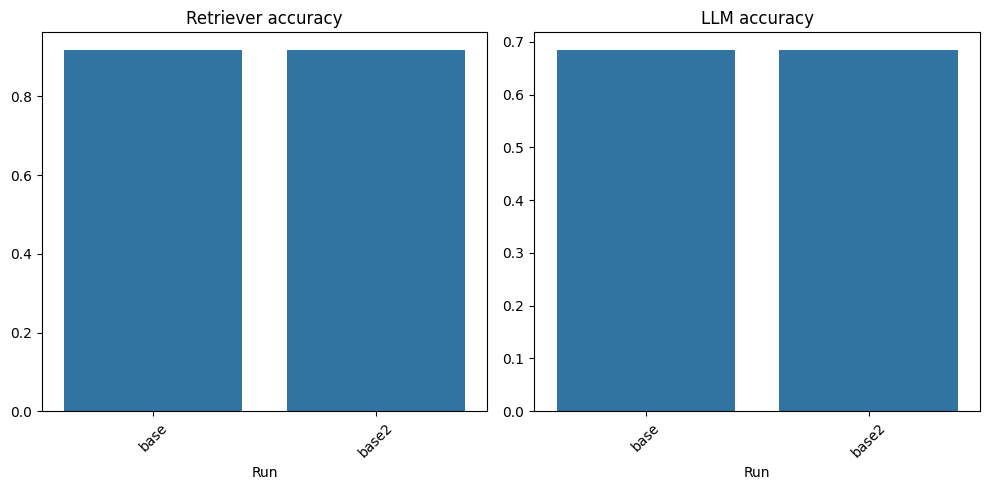

In [55]:
plot_results(['base', 'base2'])

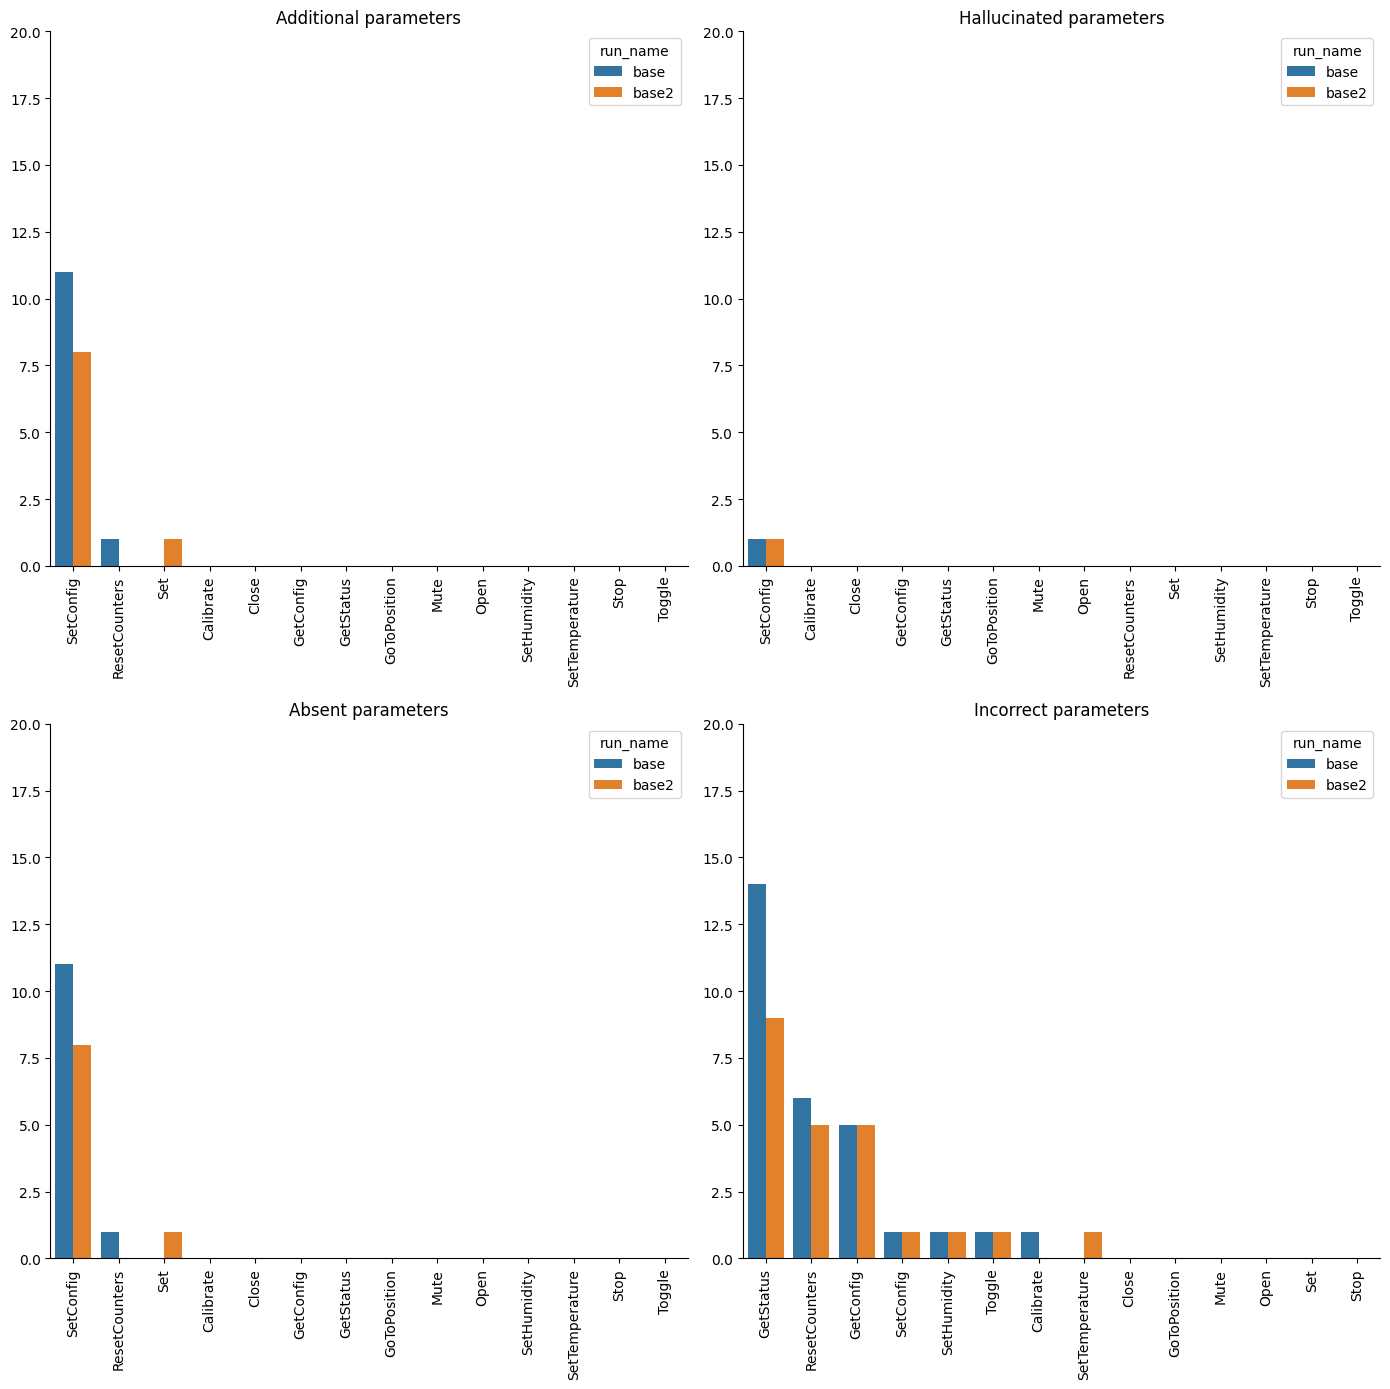

In [66]:
plot_fail_reasons(['base', 'base2'])

In [45]:
incor_params_df = df[(df['method_cor'] == True) & (df['incor'] == True)]
display(incor_params_df)

,id,device,user_cmd,gt_mtd,pred_mtd,gt_json_cmd,pred_json_cmd,method_cor,json_cor,add,hall,absent,incor
16,16,Input,Check the status of the input for the living room.,Input.GetStatus,"Input.GetStatus,Light.GetStatus,Switch.GetStatus","{""method"": ""Input.GetStatus"", ""params"": {""id"": 444}}","{""method"": ""Input.GetStatus"", ""params"": {""id"": 1}}",True,False,True,True,False,False
17,17,Input,Get details of the status for the input in the kitchen.,Input.GetStatus,"Input.GetStatus,Switch.GetStatus,Light.GetStatus","{""method"": ""Input.GetStatus"", ""params"": {""id"": 444}}","{""method"": ""Input.GetStatus"", ""params"": {""id"": 1}}",True,False,True,True,False,False
19,19,Input,Find out the status of the input for the bedroom TV.,Input.GetStatus,"Input.GetStatus,Light.GetStatus,Switch.GetStatus","{""method"": ""Input.GetStatus"", ""params"": {""id"": 444}}","{""method"": ""Input.GetStatus"", ""params"": {""id"": 3}}",True,False,True,True,False,False
20,20,Input,Retrieve the status information for the input in the study room.,Input.GetStatus,"Input.GetStatus,Light.GetStatus,Humidity.GetStatus","{""method"": ""Input.GetStatus"", ""params"": {""id"": 444}}","{""method"": ""Input.GetStatus"", ""params"": {""id"": 1}}",True,False,True,True,False,False
48,48,Light,Please provide the voltage limit for the light.,Light.GetConfig,"Light.GetConfig,Light.Set,Light.GetStatus","{""method"": ""Light.GetConfig"", ""params"": {""id"": 444}}","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}",True,False,True,True,False,False
54,54,Light,I want to reset the active energy counter for the dining room light.,Light.ResetCounters,"Light.ResetCounters,Switch.ResetCounters,Cover.ResetCounters","{""method"": ""Light.ResetCounters"", ""params"": {""id"": 444, ""type"": [""aenergy""]}}","{""method"": ""Light.ResetCounters"", ""params"": {""id"": 444, ""type"": [""activeenergy""]}}",True,False,True,True,False,False
60,60,Light,Get the total energy consumed by the main light.,Light.GetStatus,"Light.GetStatus,Light.ResetCounters,Light.GetConfig","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}","{""method"": ""Light.GetConfig"", ""params"": {""id"": 444, ""type"": [""aenergy""]}}",True,False,True,True,False,False
61,61,Light,Check if the output channel is currently on for the main light.,Light.GetStatus,"Light.GetStatus,Switch.GetStatus,Light.Toggle","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}","{""method"": ""Light.GetStatus"", ""params"": {""id"": 1}}",True,False,True,True,False,False
63,63,Light,Get the info about the temperature of the light.,Light.GetStatus,"Temperature.GetStatus,Light.GetStatus,Temperature.GetConfig","{""method"": ""Light.GetStatus"", ""params"": {""id"": 444}}","{""method"": ""Temperature.GetStatus"", ""params"": {""id"": 444}}",True,False,True,True,False,False
73,73,Light,Can you switch off the bedroom light?,Light.Toggle,"Light.SetConfig,Light.GetConfig,Light.Toggle","{""method"": ""Light.Toggle"", ""params"": {""id"": 444}}","{""method"": ""Light.Toggle"", ""params"": {""id"": 1, ""initial_state"": ""off""}}",True,False,True,True,False,False


In [74]:
df.groupby(by='gt_mtd').apply(lambda x: round(x['method_cor'].value_counts()[True] / x.shape[0], 2)).sort_values(ascending=True)

/tmp/ipykernel_2217223/41451436.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby(by='gt_mtd').apply(lambda x: round(x['method_cor'].value_counts()[True] / x.shape[0], 2)).sort_values(ascending=True)


gt_mtd
Cover.GetConfig               0.38
Temperature.GetStatus         0.50
Cover.GoToPosition            0.67
Light.Toggle                  0.67
Light.Set                     0.67
Smoke.GetConfig               0.75
Cover.GetStatus               0.88
Light.SetConfig               0.88
Input.SetConfig               0.88
Switch.SetConfig              0.88
Cover.Calibrate               1.00
Smoke.GetStatus               1.00
Switch.GetStatus              1.00
Smoke.SetConfig               1.00
Switch.GetConfig              1.00
Switch.ResetCounters          1.00
Switch.Toggle                 1.00
Temperature.GetConfig         1.00
Smoke.Mute                    1.00
Light.ResetCounters           1.00
Light.GetConfig               1.00
Temperature.SetConfig         1.00
Light.Calibrate               1.00
Input.ResetCounters           1.00
Input.GetStatus               1.00
Input.GetConfig               1.00
Humidity.SetHumidity          1.00
Humidity.SetConfig            1.00
Humidity.GetS